## Probability Distributions

author: Jacob Schreiber <br>
contact: jmschreiber91@gmail.com

This tutorial will cover the various distributions that are implemented in pomegranate. These distributions can be used by themselves, or more typically as a part of a larger compositional model like a hidden Markov model. 

The distributions that are currently available:

Univariate Distributions
    1. BernoulliDistribution
    2. BetaDistribution
    3. DiscreteDistribution
    4. ExponentialDistribution
    5. GammaDistribution
    6. LogNormalDistribution
    7. NormalDistribution
    8. PoissonDistribution
    9. UniformDistribution
  
Univariate Kernel Densities
    1. GaussianKernelDensity
    2. UniformKernelDensity
    3. TriangleKernelDensity
  
Multivariate Distributions
    1. IndependentComponentsDistribution
    2. Dirichlet Distribution
    3. MultivariateGaussianDistribution
    4. ConditionalProbabilityTable
    5. JointProbabilityTable

The following methods are supported by all distributions:

```
1. d.probability(X): Return the probability of a sample under the distribution or a vector of samples
2. d.log_probability(X): Return the log probability of a sample under the distribution or a vector of samples
3. d.fit(X, weights=None, inertia): Use MLE estimates to update the parameters of the distribution. Optional weight vector is accepted, or inertia that pushes parameters from where they currently are to the update that portion of the way.
4. d.summarize(X, weights=None): Extract and update the stored sufficient statistics on a data set with optional weights, but don't update the parameters yet
5. d.from_summaries(X, inertia=0.0): Use the stored sufficient statistics to do a parameter update
6. d.sample(n=1): Generate a sample, or a vector of samples, from the distribution

7. d.to_json(): Serialize the distribution to a string json
8. Distribution.from_json(s): Load up a stored distriibution, either from a file if passed a filename that ends in '.json', or from the string passed in itself.

9. d.copy(): Make a deep copy of the distribution
10. d.freeze(): Freeze the distribution, making 'fit' and 'from_summaries' not change model parameters
11. d.thaw(): Unfreeze the distribution so that it can be updated agin.
```

Univariate distributions also have a `plot(n=1000, **kwargs)` command, where you can plot a histogram of `n` randomly generated samples from the distribution, which will pass matplotlib keyword arguments to the `plt.hist` function. 

Lets look at a few examples.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set_style('whitegrid')
import numpy

from pomegranate import *

numpy.random.seed(0)
numpy.set_printoptions(suppress=True)

%load_ext watermark
%watermark -m -n -p numpy,scipy,pomegranate

Fri Jan 10 2020 

numpy 1.18.1
scipy 1.4.1
pomegranate 0.12.0

compiler   : Clang 10.0.0 (clang-1000.11.45.5)
system     : Darwin
release    : 17.7.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


## The API

### Initialization

Let's first look at an example of using the methods in the API. First, we can create probability distributions by passing in the parameters if we know them.

In [2]:
d = NormalDistribution(5, 2)
d2 = ExponentialDistribution(5)
d3 = LogNormalDistribution(2, 0.4)

If what you have is data and you'd like to fit your distribution to the data, rather than having parameters beforehand, you can use the `from_samples` class method to pass in the points and optional weights.

In [3]:
x = numpy.random.normal(10, 1, size=100)

d4 = NormalDistribution.from_samples(x)
d5 = ExponentialDistribution.from_samples(x)
d6 = LogNormalDistribution.from_samples(x)

If the data is univariate we can pass in a simple vector. If our data is multivariate and we'd like to fit a multivariate distribution we can pass in a matrix.

In [4]:
x = numpy.random.normal(10, 1, size=(1000, 3))

d7 = MultivariateGaussianDistribution.from_samples(x)
d7.mu, d7.cov

(array([9.94235563, 9.96112858, 9.99785915]),
 array([[ 0.98534191, -0.01989778, -0.03028855],
        [-0.01989778,  0.95247322,  0.0396411 ],
        [-0.03028855,  0.0396411 ,  0.88819551]]))

If we want to model our multivariate data with a different distribution on each feature, assuming that each feature is independent of each other, we can use an IndependentComponentsDistribution. This can be done either by passing in the distributions to the initialization, or as `from_samples`.

In [5]:
d8 = IndependentComponentsDistribution([d4, d5, d6])
d8

{
    "class" : "Distribution",
    "name" : "IndependentComponentsDistribution",
    "parameters" : [
        [
            {
                "class" : "Distribution",
                "name" : "NormalDistribution",
                "parameters" : [
                    10.05980801553448,
                    1.0078822447166023
                ],
                "frozen" : false
            },
            {
                "class" : "Distribution",
                "name" : "ExponentialDistribution",
                "parameters" : [
                    0.09940547566677038
                ],
                "frozen" : false
            },
            {
                "class" : "Distribution",
                "name" : "LogNormalDistribution",
                "parameters" : [
                    2.303462554064328,
                    0.1012880395101563
                ],
                "frozen" : false
            }
        ],
        [
            1.0,
            1.0,
            1.0
    

If we wanted to learn a multivariate Gaussian distribution but with a forced diagonal covariance matrix we can model each feature are independent normal distributions, like such.

In [6]:
d8.from_samples(x, distributions=NormalDistribution)

{
    "class" : "Distribution",
    "name" : "IndependentComponentsDistribution",
    "parameters" : [
        [
            {
                "class" : "Distribution",
                "name" : "NormalDistribution",
                "parameters" : [
                    9.942355632560583,
                    0.9926439000824223
                ],
                "frozen" : false
            },
            {
                "class" : "Distribution",
                "name" : "NormalDistribution",
                "parameters" : [
                    9.96112857784113,
                    0.9759473472188426
                ],
                "frozen" : false
            },
            {
                "class" : "Distribution",
                "name" : "NormalDistribution",
                "parameters" : [
                    9.997859147101435,
                    0.9424412506637966
                ],
                "frozen" : false
            }
        ],
        [
            1.0,
        

Note that the distributions here are displaying the mean and standard deviation, whereas the `MultivariateGaussianDistribution` is showing the mean and ~covariance~, which is the standard deviation squared. When adjusted accordingly, the means here line up with the vector of means from before, and the standard deviations are equal to the square root of the diagonal of the covariance matrix.

Lastly, if we wanted to learn an independent components distribution with different distributions on each feature, we can pass in a list of distributions.

In [7]:
d8.from_samples(x, distributions=[NormalDistribution, ExponentialDistribution, LogNormalDistribution])

{
    "class" : "Distribution",
    "name" : "IndependentComponentsDistribution",
    "parameters" : [
        [
            {
                "class" : "Distribution",
                "name" : "NormalDistribution",
                "parameters" : [
                    9.942355632560583,
                    0.9926439000824223
                ],
                "frozen" : false
            },
            {
                "class" : "Distribution",
                "name" : "ExponentialDistribution",
                "parameters" : [
                    0.10039023111442362
                ],
                "frozen" : false
            },
            {
                "class" : "Distribution",
                "name" : "LogNormalDistribution",
                "parameters" : [
                    2.297868979078352,
                    0.09529758318186476
                ],
                "frozen" : false
            }
        ],
        [
            1.0,
            1.0,
            1.0
   

### Plotting

If we want to visualize them, we can use the plot command, which randomly draws samples from the model and plots the histogram of those samples.

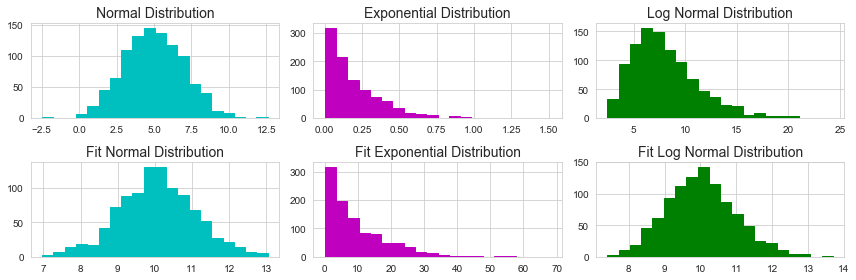

In [8]:
plt.figure(figsize=(12, 4))
plt.subplot(231)
plt.title("Normal Distribution", fontsize=14)
d.plot(1000, edgecolor='c', color='c', bins=20)

plt.subplot(232)
plt.title("Exponential Distribution", fontsize=14)
d2.plot(1000, edgecolor='m', color='m', bins=20)

plt.subplot(233)
plt.title("Log Normal Distribution", fontsize=14)
d3.plot(1000, edgecolor='g', color='g', bins=20)

plt.subplot(234)
plt.title("Fit Normal Distribution", fontsize=14)
d4.plot(1000, edgecolor='c', color='c', bins=20)

plt.subplot(235)
plt.title("Fit Exponential Distribution", fontsize=14)
d5.plot(1000, edgecolor='m', color='m', bins=20)

plt.subplot(236)
plt.title("Fit Log Normal Distribution", fontsize=14)
d6.plot(1000, edgecolor='g', color='g', bins=20)

plt.tight_layout()
plt.show()

Naturally, if you wanted smoother probability distributions, you could calculate the probability at each point along a given grid and plot those probabilities.

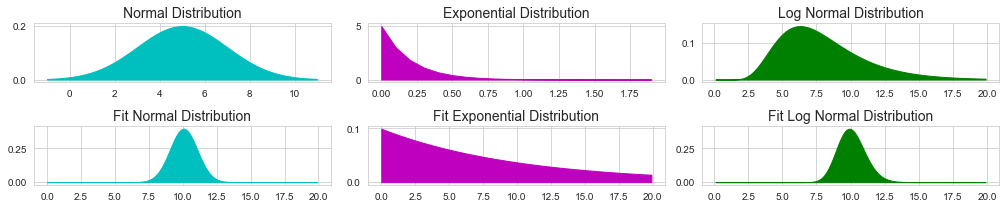

In [9]:
x1 = numpy.arange(-1, 11.1, 0.1)
x2 = numpy.arange(0, 2, 0.1)
x3 = numpy.arange(0, 20, 0.1)

plt.figure(figsize=(14, 3))
plt.subplot(231)
plt.title("Normal Distribution", fontsize=14)
plt.fill_between(x1, 0, d.probability(x1), color='c')

plt.subplot(232)
plt.title("Exponential Distribution", fontsize=14)
plt.fill_between(x2, 0, d2.probability(x2), color='m')

plt.subplot(233)
plt.title("Log Normal Distribution", fontsize=14)
plt.fill_between(x3, 0, d3.probability(x3), color='g')

plt.subplot(234)
plt.title("Fit Normal Distribution", fontsize=14)
plt.fill_between(x3, 0, d4.probability(x3), color='c')

plt.subplot(235)
plt.title("Fit Exponential Distribution", fontsize=14)
plt.fill_between(x3, 0, d5.probability(x3), color='m')

plt.subplot(236)
plt.title("Fit Log Normal Distribution", fontsize=14)
plt.fill_between(x3, 0, d6.probability(x3), color='g')

plt.tight_layout()
plt.show()

### Probability / Log Probability

All distributions can calculate probabilities and log probabilities using those respective methods. Different distributions will give very different probabilities.

In [10]:
d.probability(1), d2.probability(1), d3.probability(1)

(0.026995483256604804, 0.03368973499542734, 3.7167987868372287e-06)

A vector of values can also be passed in.

In [11]:
d.probability([1, 5, 7, 8, 3])

array([0.02699548, 0.19947114, 0.12098536, 0.0647588 , 0.12098536])

The same works for multivariate data.

In [12]:
d7.probability([[9, 10, 11]]), d8.probability([[9, 10, 11]])

(0.026023208688747114, 0.0019422749531612764)

For the independent components distribution the probability is the multiplication of the probabilities for all three dimensions.

In [13]:
d8.distributions[0].probability(9) * d8.distributions[1].probability(10) * d8.distributions[2].probability(11)

0.0019422749531612768

### Fitting

Probability distributions can be fit directly to data, as shown above, using the `from_samples` class method. However, a fit distribution can also be fit to new data using the `fit` method. This method uses maximum likelihood estimates to derive new parameters and is not affected by the current values of the distribution unless an inertia is set, which defines the proportion of the original distribution to use, the default being 0.

In [14]:
X = numpy.random.normal(6, 2, size=1000,)

d = NormalDistribution(100, 1)
d.fit(X)
d

{
    "class" :"Distribution",
    "name" :"NormalDistribution",
    "parameters" :[
        5.906921950798634,
        2.000502667681352
    ],
    "frozen" :false
}

In [15]:
d = NormalDistribution(100, 1)
d.fit(X, inertia=0.5)
d

{
    "class" :"Distribution",
    "name" :"NormalDistribution",
    "parameters" :[
        52.95346097539932,
        1.500251333840676
    ],
    "frozen" :false
}

The fit method can also be given weights, in which case weighted maximum likelihood estimates are used. This is how expectation-maximization is done for compositional models. In this next example we'll give 50 samples with mean 5 and 50 samples with mean 9 and weight those samples with mean 9 as 4 times more than those with weight 5. If the samples were unweighted one would expect the result to be 7. However, with the higher magnitude samples being weighted more heavily, the result will actually be closer to 9.

In [16]:
X = numpy.random.normal(5, 2, size=100,)
X[50:] += 4

w = numpy.ones(100)
w[:50] = 0.25

d = NormalDistribution(10, 1)
d.fit(X, w)
d

{
    "class" :"Distribution",
    "name" :"NormalDistribution",
    "parameters" :[
        8.228881313766124,
        2.5257422669054432
    ],
    "frozen" :false
}

## Discrete Distributions

A notable deviant from the numerics logic is the Discrete Distribution. Instead of passing parameters as floats, you instead pass in a dictionary where keys can be any objects and values are the probability of them occurring. Internally the objects that are the keys get converted to integer indices to an array whose values are the probability of that integer occuring. All models store a keymap that converts the inputs to those models to the indices of the discrete distribution. If you try to calculate the log probability of an item not present in the distribution, the default behavior is to return negative infinity, or 0.0 probability.

In [18]:
d = DiscreteDistribution({'A': 0.1, 'C': 0.25, 'G': 0.50, 'T': 0.15})
print(d.probability( 'A'))
print(d.probability( 'G'))
print(d.probability('????'))

0.10000000000000002
0.5
0.0


Updating a discrete distributon is the same as updating other distributions.

In [19]:
X = list('ACGATACACTGAATGACAGCAGTCACTGACAGTAGTACGAGTAGTAGCAGAGAGTAATAAAGAATTAATATATGACACTACGAAAAAAATGCATCG')

d.fit(X)

print d.parameters[0]
print 1. * numpy.unique(X, return_counts=True)[1] / len(X)

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(d.parameters[0])? (<ipython-input-19-7c05880e7290>, line 5)

### The Kernel Density

The Gaussian Kernel Density is a non-parametric distribution that, instead of parameters, stores the data points that it was trained on directly. When initializing a kernel density you simply pass in the points. These points are converted to a probability distribution by essentially dropping some probability distribution on top of each point and then dividing the density by the number of points, ensuring that the area still integrates to 1. We can see this in action with the Gaussian kernel density which drops a normal distribution on each point with standard deviation equal to the bandwidth.

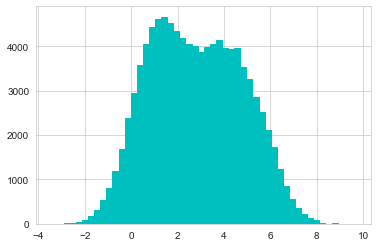

In [20]:
d = GaussianKernelDensity( [0.5, 1.2, 4.2, 1.9, 5.4, 3.4], bandwidth=1 )
d.plot(n=100000, edgecolor='c', color='c', bins=50)
plt.show()

Changing the bandwidth parameter is equivalent to reducing the variance on a Gaussian. It makes the densities more central around the points, but can cause overfitting.

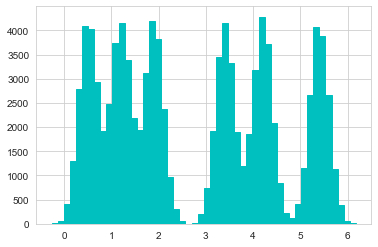

In [21]:
d = GaussianKernelDensity( [0.5, 1.2, 4.2, 1.9, 5.4, 3.4], bandwidth=0.2 )
d.plot(n=100000, edgecolor='c', color='c', bins=50)

Passing in weights can change the influence of each sample for the final probability distribution.

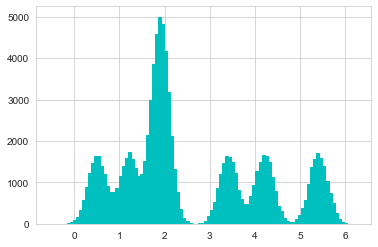

In [22]:
d = GaussianKernelDensity( [0.5, 1.2, 4.2, 1.9, 5.4, 3.4], weights=[1, 1, 1, 3, 1, 1], bandwidth=0.2 )
d.plot( n=100000, edgecolor='c', color='c', bins=100 )

## Out-of-core learning

Distributions also have the `summarize` and `from_summaries` method that implement out-of-core learning. More will be available in the out-of-core learning tutorial, but the gist is that you can train on an amount of data that doesn't fit in memory and still yield exact updates. This works for any model in pomegranate, but lets illustrate it for an independent components distribution made up of three very different distributions.

In [23]:
from pomegranate import *
import numpy

X = numpy.random.normal(16, 1, size=(1000, 3))

d = IndependentComponentsDistribution([NormalDistribution(5, 1), 
                                       ExponentialDistribution(7), 
                                       LogNormalDistribution(0.6, 0.3)])

d2 = d.copy()

d.summarize(X[:500])
d.summarize(X[500:])
d.from_summaries()
d

{
    "class" : "Distribution",
    "name" : "IndependentComponentsDistribution",
    "parameters" : [
        [
            {
                "class" : "Distribution",
                "name" : "NormalDistribution",
                "parameters" : [
                    15.975331623897382,
                    0.9839454537443147
                ],
                "frozen" : false
            },
            {
                "class" : "Distribution",
                "name" : "ExponentialDistribution",
                "parameters" : [
                    0.06273786783336628
                ],
                "frozen" : false
            },
            {
                "class" : "Distribution",
                "name" : "LogNormalDistribution",
                "parameters" : [
                    2.7687181529109424,
                    0.06401250783319416
                ],
                "frozen" : false
            }
        ],
        [
            1.0,
            1.0,
            1.0
 

In [24]:
d2.fit(X)
d2

{
    "class" : "Distribution",
    "name" : "IndependentComponentsDistribution",
    "parameters" : [
        [
            {
                "class" : "Distribution",
                "name" : "NormalDistribution",
                "parameters" : [
                    15.975331623897368,
                    0.9839454537444303
                ],
                "frozen" : false
            },
            {
                "class" : "Distribution",
                "name" : "ExponentialDistribution",
                "parameters" : [
                    0.06273786783336632
                ],
                "frozen" : false
            },
            {
                "class" : "Distribution",
                "name" : "LogNormalDistribution",
                "parameters" : [
                    2.7687181529109472,
                    0.06401250783306929
                ],
                "frozen" : false
            }
        ],
        [
            1.0,
            1.0,
            1.0
 

We can also take a look at the JSON serialization. JSONs are the perfect way to store these models given their human interpretability, and the ability to recursively store JSONs within other JSONs, such as more complicated models (such as HMMs) will need to store the JSON of each distribution. It is useful to store these models after the computationally intensive task of training them, so that it need not be repeated.

In [26]:
print(d.to_json())

{
    "class" : "Distribution",
    "name" : "IndependentComponentsDistribution",
    "parameters" : [
        [
            {
                "class" : "Distribution",
                "name" : "NormalDistribution",
                "parameters" : [
                    15.975331623897368,
                    0.9839454537444303
                ],
                "frozen" : false
            },
            {
                "class" : "Distribution",
                "name" : "ExponentialDistribution",
                "parameters" : [
                    0.06273786783336632
                ],
                "frozen" : false
            },
            {
                "class" : "Distribution",
                "name" : "LogNormalDistribution",
                "parameters" : [
                    2.7687181529109472,
                    0.06401250783306929
                ],
                "frozen" : false
            }
        ],
        [
            1.0,
            1.0,
            1.0
 

## Serialization

Distributions (except tables right now) support serialization to JSONs using `to_json()` and `Distribution.from_json(json)`. We can see a few examples easily.

In [27]:
print(NormalDistribution(5, 2).to_json())

{
    "class" :"Distribution",
    "name" :"NormalDistribution",
    "parameters" :[
        5.0,
        2.0
    ],
    "frozen" :false
}


In [28]:
print(DiscreteDistribution({'A': 0.5, 'B': 0.25, 'C': 0.25}).to_json())

{
    "class" :"Distribution",
    "dtype" :"str",
    "name" :"DiscreteDistribution",
    "parameters" :[
        {
            "A" :0.5,
            "B" :0.25,
            "C" :0.25
        }
    ],
    "frozen" :false
}


In [29]:
print(GammaDistribution(5, 2).to_json())

{
    "class" :"Distribution",
    "name" :"GammaDistribution",
    "parameters" :[
        5.0,
        2.0
    ],
    "frozen" :false
}


We can load them up using the base Distribution class. This is done because, when storing compositional models, they typically don't know what type of distribution is being stored.

In [30]:
NormalDistribution(1, 1).probability(3)

0.05399096651320961

In [31]:
Distribution.from_json(NormalDistribution(1, 1).to_json()).probability(3)

0.05399096651320961